#### This code builds and implements Regression Tree based methods to predict pollution in Delhi using fire incidents in Punjab

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import os
# gradient boosting 
from xgboost import XGBRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# evaluation metrics
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.tsatools import lagmat


In [71]:
#Load cleaned data

work = pd.read_csv('working_ML.csv')

work = work.drop(columns = ['Unnamed: 0','incident_day', 'state_name', 
                                    'state_name_x_x', 
                                    'state_name_y_x', 'state_name_x_y', 'state_name_y_y', 
                                    'state_code','satellite_instrument'])


work['incident_dt'] = pd.to_datetime(work['incident_dt'])
work['incident_month'] = work['incident_dt'].dt.month
work['incident_yr'] = work['incident_dt'].dt.year
work['incident_week'] = work['incident_dt'].dt.isocalendar().week

#fill missing data
work['count_of_incidents'] = (work['count_of_incidents'].ffill() + work['count_of_incidents'].bfill())/2

#Drop post Covid observs

work = work.loc[work['incident_my'] <= '2020-02',:]

#one hot code the variables

work = pd.get_dummies(work, columns = ['incident_week'])

#Restrict to just peak fire activity months
work_peak = work.loc[work['incident_month'].isin([5,10,11]),]

work = pd.get_dummies(work, columns = ['incident_month'])
work_peak = pd.get_dummies(work_peak, columns = ['incident_month'])
#Pollution baseline

aod_mean_base = work.loc[work['incident_yr'] <= 2010,'stat'].mean()

aod_mean_base_peak = work_peak.loc[work_peak['incident_yr'] <= 2010,'stat'].mean()

#Only keep obs post 2012 (we are using VIIRS data)
work = work.loc[work['incident_dt'] >= '2012-01-21',]

work_peak = work_peak.loc[work_peak['incident_dt'] >= '2012-01-21',]


work = pd.get_dummies(work, columns = ['incident_yr'])

work_peak = pd.get_dummies(work_peak, columns = ['incident_yr'])

work['incident_month'] = work['incident_dt'].dt.month
work['incident_yr'] = work['incident_dt'].dt.year

#work.loc[work['aod_rescaled'] >= 3.0,'aod_rescaled'] = 3

work['aod_anomaly'] = work['stat'] - aod_mean_base

work_peak['aod_anomaly'] = work_peak['stat'] - aod_mean_base_peak

work_peak.columns

Index(['incident_dt', 'stat', 'count_of_incidents', 'incident_my',
       't2m_mean_del', 'rainfall_mm_del', 't2m_mean_punj', 'rainfall_mm_punj',
       'wind_speed_del', 'wind_dir_del', 'wind_speed_punj', 'wind_dir_punj',
       'incident_week_1', 'incident_week_2', 'incident_week_3',
       'incident_week_4', 'incident_week_5', 'incident_week_6',
       'incident_week_7', 'incident_week_8', 'incident_week_9',
       'incident_week_10', 'incident_week_11', 'incident_week_12',
       'incident_week_13', 'incident_week_14', 'incident_week_15',
       'incident_week_16', 'incident_week_17', 'incident_week_18',
       'incident_week_19', 'incident_week_20', 'incident_week_21',
       'incident_week_22', 'incident_week_23', 'incident_week_24',
       'incident_week_25', 'incident_week_26', 'incident_week_27',
       'incident_week_28', 'incident_week_29', 'incident_week_30',
       'incident_week_31', 'incident_week_32', 'incident_week_33',
       'incident_week_34', 'incident_week_35', 'i

In [72]:
#Only retain observations before Covid (external shock on pollution levels
#which the model doesn't account for)

#Peak period 
work = work.loc[work['incident_my'] <= '2020-02',:]
work_peak = work_peak.loc[work_peak['incident_my'] <= '2020-02',:]



In [73]:

X_df_reg = work_peak.drop(columns = ['stat', 'incident_my', 'incident_dt'])
y_reg = work_peak['aod_anomaly']

work_predictors = X_df_reg[['aod_anomaly','count_of_incidents', 't2m_mean_punj', 
             'rainfall_mm_punj', 'wind_speed_punj', 'wind_dir_punj', 'wind_speed_del', 
             'wind_dir_del', 't2m_mean_del', 'rainfall_mm_del']]

work_Dum = X_df_reg.drop(columns = ['aod_anomaly','count_of_incidents', 't2m_mean_punj', 
             'rainfall_mm_punj', 'wind_speed_punj', 'wind_dir_punj', 'wind_speed_del', 
             'wind_dir_del', 't2m_mean_del', 'rainfall_mm_del'])

work_predictors_lag = lagmat(work_predictors, maxlag = 4, trim = 'both', use_pandas=True)

work_predictors = work_predictors.join(work_predictors_lag, how = 'inner')
work_predictors = work_predictors.join(work_Dum)

X_df = work_predictors.drop(columns = ['aod_anomaly'])
X_df.columns                            
#drop NAs

#Then join with other dummies
y_reg = y_reg[4:]
X_df

X = X_df.to_numpy()
y = y_reg.to_numpy()

In [74]:
#Split into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 20221107)

print(X_train.shape,y_train.shape)

(512, 113) (512,)


In [23]:
X_df_reg.columns

Index(['incident_dt', 'count_of_incidents', 't2m_mean_del', 'rainfall_mm_del',
       't2m_mean_punj', 'rainfall_mm_punj', 'wind_speed_del', 'wind_dir_del',
       'wind_speed_punj', 'wind_dir_punj', 'incident_week_1',
       'incident_week_2', 'incident_week_3', 'incident_week_4',
       'incident_week_5', 'incident_week_6', 'incident_week_7',
       'incident_week_8', 'incident_week_9', 'incident_week_10',
       'incident_week_11', 'incident_week_12', 'incident_week_13',
       'incident_week_14', 'incident_week_15', 'incident_week_16',
       'incident_week_17', 'incident_week_18', 'incident_week_19',
       'incident_week_20', 'incident_week_21', 'incident_week_22',
       'incident_week_23', 'incident_week_24', 'incident_week_25',
       'incident_week_26', 'incident_week_27', 'incident_week_28',
       'incident_week_29', 'incident_week_30', 'incident_week_31',
       'incident_week_32', 'incident_week_33', 'incident_week_34',
       'incident_week_35', 'incident_week_36', 'inci

### Regression Tree

In [75]:
# Shuffle the training set
order = np.argsort(np.random.random(y_train.shape))
X_train = X_train[order]
y_train = y_train[order]

print("Training set: {}".format(X_train.shape))  # 512 examples, 113 features
print("Testing set:  {}".format(X_test.shape))   # 220 examples, 113 features

Training set: (512, 113)
Testing set:  (220, 113)


### Build the Model

In [76]:
#======================================================
# Xtreme Gradient Boosting Regressor
#======================================================

modelxgb = XGBRegressor(seed = 20211221)

params_xgb = {'objective': ['reg:squarederror'], 'max_depth': [10,20,50],
           'learning_rate': [0.01, 0.001],
           'n_estimators': [500, 1000, 2000, 4000],
           'reg_alpha': [1],
              'reg_lambda': [0]}

#%%time
gridxgb = GridSearchCV(estimator=modelxgb, 
                   param_grid = params_xgb,
                   scoring='neg_mean_squared_error', 
                   verbose=0, cv = 3)

gridxgb_result = gridxgb.fit(X_train, y_train)

print("Best parameters:", gridxgb.best_params_)
print("Lowest RMSE: ", (-gridxgb.best_score_)**(1/2.0))


Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'reg_alpha': 1, 'reg_lambda': 0}
Lowest RMSE:  0.5481776261449091


RMS: 0.5133999331144422
0.5567225745654265


/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_24253/3043980155.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot( x = y_test, y = test_predictions, label = 'xgb', color = 'r',palette='Set2')


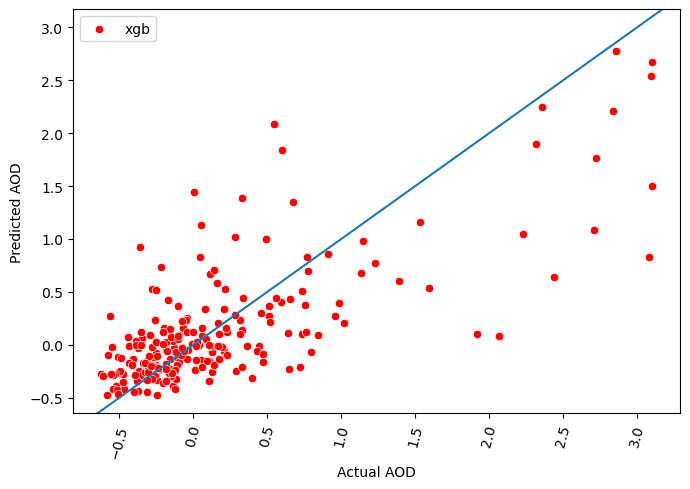

In [78]:
##now, run the best model and plot the results
os.chdir('/Users/abhishekdeshwal/Desktop/Homework/Sem III/Machine Learning/Final Project/output')

params = {'objective': 'reg:squarederror',
              #'base_score': 0.5,     # chosen as median of validation set
              'n_estimators': 1000,  # number of trees to use
              'learning_rate': 0.01, 
              'max_depth': 10,       # how many levels are in each tree
              #'subsample': 1,
              #'colsample_bytree': 0.8,
              # REGULARIZATION  alpha (L2) and lambda (L1)
              'reg_alpha': 1,
              'reg_lambda': 0,}


best_model = XGBRegressor(seed = 20211221, **params)
best_model.fit(X_train, y_train)
test_predictions = best_model.predict(X_test)

print("RMS: %s" % np.sqrt(np.mean((y_test - test_predictions) ** 2)))
print(r2_score(y_test,test_predictions)) #Decent R-sqaured  #0.52 (because of shuffling?)
plt.figure(figsize=(7, 5), tight_layout=True)
ax = sns.scatterplot( x = y_test, y = test_predictions, label = 'xgb', color = 'r',palette='Set2')
ax.set(ylabel = 'Predicted AOD', xlabel = 'Actual AOD')
ax.axline((0,0),(3,3))    
plt.xticks(rotation = 75)
plt.savefig('fit_xgb.pdf', bbox_inches = 'tight')
plt.show()


In [82]:
#####      Random Forest Regressor        #####
###############################################

modelrfr = RandomForestRegressor()

params_rfr = {'criterion':['mse'], 'max_depth': [10,20,50],
           'n_estimators': [500, 1000, 2000, 4000],
           'bootstrap':[True],
              'max_features':[None]}

#%%time
gridrfr = GridSearchCV(estimator=modelrfr, 
                   param_grid = params_rfr,
                   scoring='neg_mean_squared_error', 
                   verbose=0, cv = 3)

gridrfr_result = gridrfr.fit(X_train, y_train)

print("Best parameters:", gridrfr.best_params_)
print("Lowest RMSE: ", (-gridrfr.best_score_)**(1/2.0))



/Users/abhishekdeshwal/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/abhishekdeshwal/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/abhishekdeshwal/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/abhishekdeshwal/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='s

Best parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 50, 'max_features': None, 'n_estimators': 1000}
Lowest RMSE:  0.5266300917193418


/Users/abhishekdeshwal/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


RMS: 0.5242417524551883
0.5378029037404688


/var/folders/qy/t23x7wnj1llfk59xmchk96880000gn/T/ipykernel_24253/1391068752.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot( x = y_test, y = test_predictions, label = 'rfr', color = 'r',palette='Set2')


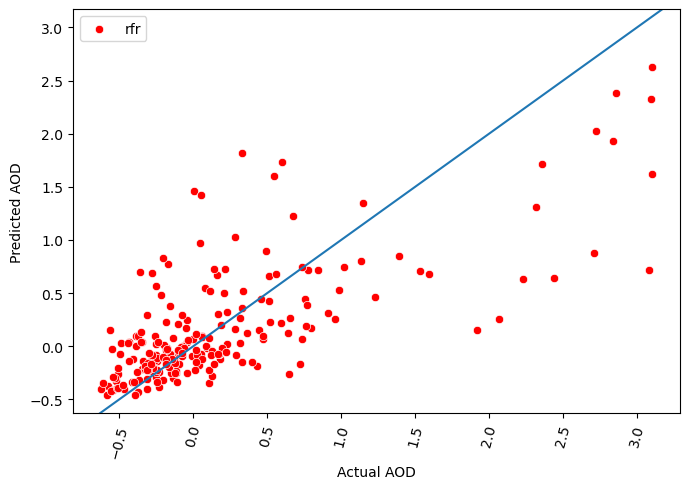

In [83]:
params = {'n_estimators':1000,
              'criterion':'mse', 
              #'ccp_alpha':0.001,
              'max_depth': 50,
              #'min_samples_leaf':1,
              #'min_samples_split':5,
              'bootstrap':True,
              'max_features':None}


best_model = RandomForestRegressor(**params)
best_model.fit(X_train, y_train)
test_predictions = best_model.predict(X_test)

print("RMS: %s" % np.sqrt(np.mean((y_test - test_predictions) ** 2)))
print(r2_score(y_test,test_predictions)) #Decent R-sqaured  #0.52 (because of shuffling?)
plt.figure(figsize=(7, 5), tight_layout=True)
ax = sns.scatterplot( x = y_test, y = test_predictions, label = 'rfr', color = 'r',palette='Set2')
ax.set(ylabel = 'Predicted AOD', xlabel = 'Actual AOD')
ax.axline((0,0),(3,3))    
plt.xticks(rotation = 75)
plt.savefig('fit_rfr.pdf', bbox_inches = 'tight')
plt.show()
